# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [ ]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from math import e
import matplotlib.pyplot as plt
import time

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state, shuffle

from keras.datasets import mnist

X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#Implementacja



In [ ]:
def mean_square_error(y:np.ndarray, expected_y:np.ndarray):
    return (y - expected_y)**2/np.size(expected_y)

def mean_square_error_deriviative(y:np.ndarray, expected_y:np.ndarray):
    return 2 * (y- expected_y) / np.size(expected_y)

In [ ]:
def tangh(x:float) -> float:
    # return 2/(1+e**(-2*x))-1
    return (e**x - e**(-x))/(e**x+e**(-x))

def tangh_dereviative(x:float) -> float:
    return 1 - tangh(x)**2

In [ ]:
CHECK_RUNS_FOR_EPOCH = 500
CHECK_RUNS_FOR_BATCH = 100

def desired_output_vector(size: int, y: int) -> np.ndarray:
    return np.reshape(np.array([0.0 if i != y else 1 for i in range(size)]), [size, 1])

class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01
        self._input = np.array([])
        self._output = np.array([])

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, max_start_weight_value: int = 0.1) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(self.output_size, self.input_size)*max_start_weight_value
        self.bias = np.random.rand(self.output_size, 1)

    def forward(self, x:np.ndarray)->np.ndarray:
        self._input = x
        self._output = np.dot(self.weights, x) + self.bias
        return self._output

    def backward(self, output_error_derivative)->np.ndarray:
        weights_gradient = np.dot(output_error_derivative, self._input.T)
        input_gradient = np.dot(self.weights.T, output_error_derivative)
        self.weights -=  weights_gradient * self.learning_rate
        self.bias -= output_error_derivative * self.learning_rate
        return input_gradient

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self._input = x
        self._output = tangh(x)
        return self._output

    def backward(self, output_error_derivative)->np.ndarray:
        return np.multiply(output_error_derivative, tangh_dereviative(self._input))

class Flatten(Layer):
  def __init__(self, input_size: int, devision_factor: float) -> None:
      super().__init__()
      self.input_size = input_size
      self.devision_factor = devision_factor

  def forward(self, x: np.ndarray) -> np.ndarray:
      return np.reshape(x, [self.input_size, 1])/self.devision_factor

  def backward(self, output_error_derivative) -> np.ndarray:
      return output_error_derivative

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        print(loss_function_derivative)
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y:np.ndarray, expected_y:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(expected_y, y)

    def loss_derivative(self, y:np.ndarray, expected_y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(y, expected_y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.loss: Loss
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

    def set_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss
        pass

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            verbose:int=1)->None:
        """Fit the network to the training data
           x_train is an np.ndarray of shape (number_of_smaples, input_number_of_first_neuron, 1)
           y_train is an np.ndarray of ints tat reprezent which output neuron must be 1"""
        for i in range(epochs):
          print(f"Epoch {i+1} started")
          x_train, y_train = shuffle(x_train, y_train, random_state=123) #its constant only to make tests repeatable
          for x, expected_y in zip(x_train, y_train):
            y = self.__call__(x)
            self._backward_propagation_grad(expected_y, y)
          random_test_num = np.random.randint(len(x_train)-1, size=CHECK_RUNS_FOR_EPOCH)
          self.log_progres_per_epoch([x_train[j] for j in random_test_num], [y_train[j] for j in random_test_num], i + 1, verbose)

    def _backward_propagation_grad(self, expected_y: int, y: np.ndarray):
        grad_input = self.loss.loss_derivative(y, expected_y)
        for layer in reversed(self.layers):
            grad_input = layer.backward(grad_input)
        return grad_input

    def measure_current_loss(self, x_vect, expected_y):
        loss = np.zeros(expected_y[0].shape)
        for x, y in zip(x_vect, expected_y):
          loss = loss + self.loss.loss(self(x), y)
        return loss/len(x_vect)

    def log_progres_per_epoch(self, x, expected_y, epoch: int , verbose: int):
        print(f"Epoch {epoch} ended")
        if verbose == 1:
            print(f"Current Losss: {self.measure_current_loss( x, expected_y)}")
        if verbose == 2:
            print(f"Current accuracy: {self.measure_accuracy( x, expected_y)}")
    def measure_accuracy(self, x, expected_y) -> float:
        errors = 0
        for ex_x, ex_y in zip(x, expected_y):
          if np.argmax(self(ex_x)) != np.argmax(ex_y):
            errors += 1
        return 1 - errors/len(expected_y)

In [ ]:
def normalize_input(x:np.ndarray, input_size: int = 784):
    return np.divide(np.reshape(x, [x.shape[0], input_size, 1]), 256)

def normalize_expected_output(y: np.ndarray, size: int):
    return np.array([desired_output_vector(size, int(str_y)) for str_y in y])

#XOR


Na początku zaprezentowałem (przy pomocy nieco zmodyfikowanego kodu) co się dzieje w sieci neuronowej podczas wstecznej propagacji na przykładzie sieci stworzonej do imitacji brami XOR. Widać tu jaka jest wartość gradientu na wyjściu bramiki i jaka na wejściu po przejściu wstecz. Można też zauważyć o ile zmieniły się wagi (o ile się zwiększyły) i jak to wpłyneło na wyjście sieci neuronowej.

In [ ]:
# the output is presented with modified code to enchance the presentation

# x_train = np.array([[1,1], [0, 1]])
# x_train = np.reshape(x_train, (2, 2, 1))
# y_train = np.array([x[0]^x[1] for x in x_train])


# nn = Network([FullyConnected(2, 3, 0.5),Tanh(), FullyConnected(3, 1, 0.5),Tanh()], 0.4)
# nn.compile(Loss(mean_square_error, mean_square_error_deriviative))
# nn.fit(x_train, y_train, 1)


<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Input: [[0 1]], Expected output [1], Recieved output [[0.32184181]], Loss: [[0.45989853]]
Loss derieviative [[-1.35631638]]
output gradient Tanh layer [[-1.35631638]]
output gradient Tanh layer [[-1.21582621]]
output gradient FullyConnected layer [[-1.21582621]]
weights changed by [[0.20432454 0.23038027 0.38772413]]
bias changed by [[0.48633049]]
input gradient FullyConnected layer [[-0.14128619]
 [-0.21810441]
 [-0.05973037]]
output gradient Tanh layer [[-0.14128619]
 [-0.21810441]
 [-0.05973037]]
output gradient Tanh layer [[-0.11634726]
 [-0.16916125]
 [-0.02176585]]
output gradient FullyConnected layer [[-0.11634726]
 [-0.16916125]
 [-0.02176585]]
weights changed by [[-0.          0.04653891]
 [-0.          0.0676645 ]
 [-0.          0.00870634]]
bias changed by [[0.04653891]
 [0.0676645 ]
 [0.00870634]]
input gradient FullyConnected layer [[-0.05015875]
 [-0.06831923]]
After backward propagation Input: [[0

In [ ]:
number_of_samples = 1000

x_train = np.random.randint(2, size=(number_of_samples, 2))
x_train = np.reshape(x_train, (number_of_samples, 2, 1))
y_train = np.array([x[0]^x[1] for x in x_train])

nn = Network([FullyConnected(2, 3, 0.5),Tanh(), FullyConnected(3, 1, 0.5),Tanh()], 0.1)
nn.compile(Loss(mean_square_error, mean_square_error_deriviative))
nn.fit(x_train, y_train, 1)

print("\nTest dokładności")
print(f"input: 0 0, output: {nn(np.array([[0], [0]]))}")
print(f"input: 1 0, output: {nn(np.array([[1], [0]]))}")
print(f"input: 0 1, output: {nn(np.array([[0], [1]]))}")
print(f"input: 1 1, output: {nn(np.array([[1], [1]]))}")

<function mean_square_error_deriviative at 0x7cac59447010>
Epoch 1 started
Epoch 1 ended
Current Losss: [[2.626]]

Test dokładności
input: 0 0, output: [[-1.]]
input: 1 0, output: [[-1.]]
input: 0 1, output: [[-1.]]
input: 1 1, output: [[-1.]]


Zauważyłem, że w tym przypadku dopiero przy około 800 próbkach dostajemy wyniki zgodne z oczekiwanymi (tzn wyjścia sią bliżej tego czego oczekiwalibyśmy od bramik XOR). Jest bardzo prawdopodobne że w takim przypadku (jakiegoś elementu z dziadziny sygnałów cyfrowych) funkcja Tanh jest nieodpowiednią funkcją aktywacji i np. binary step czy Relu byłyby lepsze i dwałyby lepsze wyniki szybciej. Zwłaszcza, przy odpowiedznie architekturze, dla binary step na wyjściu otrzymywalibyśmy zawsze 0 lub 1.  

In [ ]:
number_of_samples = 100
number_of_epochs = 18

x_train = np.random.randint(2, size=(number_of_samples, 2))
x_train = np.reshape(x_train, (number_of_samples, 2, 1))
y_train = np.array([x[0]^x[1] for x in x_train])

nn = Network([FullyConnected(2, 3, 0.5),Tanh(), FullyConnected(3, 1, 0.5),Tanh()], 0.1)
nn.compile(Loss(mean_square_error, mean_square_error_deriviative))
nn.fit(x_train, y_train, number_of_epochs)

print("\nTest dokładności")
print(f"input: 0 0, output: {nn(np.array([[0], [0]]))}")
print(f"input: 1 0, output: {nn(np.array([[1], [0]]))}")
print(f"input: 0 1, output: {nn(np.array([[0], [1]]))}")
print(f"input: 1 1, output: {nn(np.array([[1], [1]]))}")

<function mean_square_error_deriviative at 0x7cac59447010>
Epoch 1 started
Epoch 1 ended
Current Losss: [[2.32]]
Epoch 2 started
Epoch 2 ended
Current Losss: [[2.416]]
Epoch 3 started
Epoch 3 ended
Current Losss: [[2.374]]
Epoch 4 started
Epoch 4 ended
Current Losss: [[2.392]]
Epoch 5 started
Epoch 5 ended
Current Losss: [[2.41]]
Epoch 6 started
Epoch 6 ended
Current Losss: [[2.374]]
Epoch 7 started
Epoch 7 ended
Current Losss: [[2.368]]
Epoch 8 started
Epoch 8 ended
Current Losss: [[2.446]]
Epoch 9 started
Epoch 9 ended
Current Losss: [[2.23]]
Epoch 10 started
Epoch 10 ended
Current Losss: [[2.356]]
Epoch 11 started
Epoch 11 ended
Current Losss: [[2.398]]
Epoch 12 started
Epoch 12 ended
Current Losss: [[2.344]]
Epoch 13 started
Epoch 13 ended
Current Losss: [[2.446]]
Epoch 14 started
Epoch 14 ended
Current Losss: [[2.398]]
Epoch 15 started
Epoch 15 ended
Current Losss: [[2.308]]
Epoch 16 started
Epoch 16 ended
Current Losss: [[2.398]]
Epoch 17 started
Epoch 17 ended
Current Losss: [[2

#Test dokładności na przykładowej sieci na przykładowych danych

In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)
neural_network = Network([FullyConnected(784, 30),Tanh(), FullyConnected(30, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x), normalize_expected_output(y, 10), 5, 2)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 [1.9290298 ]
 [1.7769801 ]
 [2.04095764]
 [1.46907135]
 [1.98308395]
 [2.13989179]
 [2.04673975]
 [2.20117275]
 [2.02899455]]
[[0.02700048]
 [0.08098076]
 [0.10816637]
 [0.0652787 ]
 [0.19107936]
 [0.0729916 ]
 [0.05388029]
 [0.06455278]
 [0.04781578]
 [0.0668057 ]]
aaaaaa
[[5.1720802 ]
 [5.45671138]
 [5.91526475]
 [5.31120348]
 [5.10521907]
 [5.80256826]
 [5.85806494]
 [5.11374441]
 [5.05570007]
 [5.64765625]
 [5.84988605]
 [5.31284894]
 [5.42869931]
 [5.89229138]
 [5.06671914]
 [5.69048623]
 [5.9549228 ]
 [5.0845558 ]
 [5.32305851]
 [5.47931112]
 [5.51230465]
 [5.70355989]
 [5.49677386]
 [5.37914222]
 [5.49038785]
 [5.13731576]
 [5.28113648]
 [5.26353272]
 [5.70793722]
 [5.92468039]]
[[1.28712361e-04]
 [7.28458620e-05]
 [2.91152143e-05]
 [9.74509554e-05]
 [1.47126568e-04]
 [3.64758416e-05]
 [3.26439231e-05]
 [1.44639403e-04]
 [1.62442412e-04]
 [4.97229973e-05]
 [3.31822878e-05]
 [9.71307951e-05]
 [7.70433141e-05]
 [3.0

KeyboardInterrupt: 

In [ ]:
print("Test for example data")
nn_y = neural_network(normalize_input(X)[51])
print(f"Expected {y[51]}, Received {np.argmax(nn_y)}")
print(f"Neural network output {nn_y.T}")
print("----------------------------------------------")
nn_y = neural_network(normalize_input(X)[123])
print(f"Expected {y[123]}, Received {np.argmax(nn_y)}")
print(f"Neural network output {nn_y.T}")

Test for example data
Expected 0, Received 0
Neural network output [[nan nan nan nan nan nan nan nan nan nan]]
----------------------------------------------
Expected 7, Received 0
Neural network output [[nan nan nan nan nan nan nan nan nan nan]]


In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)
neural_network = Network([FullyConnected(784, 30),Tanh(), FullyConnected(30, 10), Tanh()], 0.5)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x), normalize_expected_output(y, 10), 5, 2)

<function mean_square_error_deriviative at 0x7855a922b7f0>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.874
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.776
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.904
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.644
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.88


In [ ]:
print("Test for example data")
nn_y = neural_network(normalize_input(X)[51])
print(f"Expected {y[51]}, Received {np.argmax(nn_y)}")
print(f"Neural network output {nn_y.T}")
print("----------------------------------------------")
nn_y = neural_network(normalize_input(X)[123])
print(f"Expected {y[123]}, Received {np.argmax(nn_y)}")
print(f"Neural network output {nn_y.T}")

Test for example data
Expected 0, Received 0
Neural network output [[ 0.79007348  0.01598856  0.11344439 -0.22121298 -0.11676049  0.25462059
  -0.05252169  0.32218951  0.09732982 -0.00556812]]
----------------------------------------------
Expected 7, Received 7
Neural network output [[-0.02209488  0.04195141  0.04345087 -0.15637043 -0.14026915  0.21442179
   0.03273021  0.97536679 -0.13530987  0.02789396]]


<function mean_square_error_deriviative at 0x7855a922b7f0>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.876
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.832
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.878
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.89
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.91
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.886
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.918
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.888
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.89
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.89


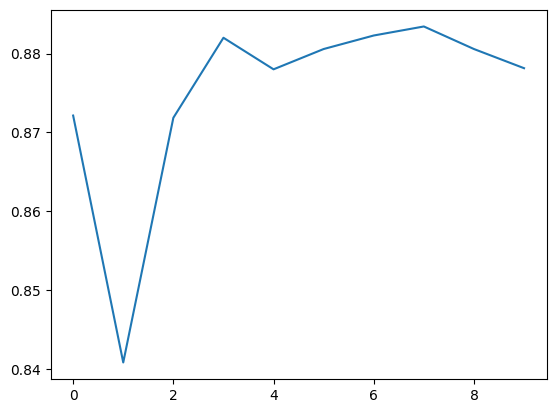

In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)
epoch_number = 10
neural_network = Network([FullyConnected(784, 30),Tanh(), FullyConnected(30, 10), Tanh()], 0.5)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
test_errors = []
for i in range(epoch_number):
  neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 1, 2)
  test_errors.append(neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10)))
plt.plot(test_errors)

<function mean_square_error_deriviative at 0x7855a922b7f0>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.716
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.892
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.864
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.902
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.9
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.91
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.896
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.946
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.9339999999999999
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.9299999999999999
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.9339999999999999
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.9319999999999999
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.916
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.924
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.926
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.914
Epoch 1 started
Epoch 1 ende

Text(0, 0.5, 'Dokładność')

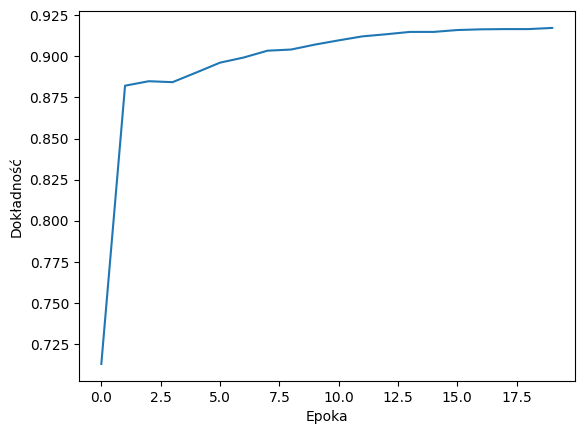

In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)
epoch_number = 20
neural_network = Network([FullyConnected(784, 30),Tanh(), FullyConnected(30, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
test_errors = []
for i in range(epoch_number):
  neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 1, 2)
  test_errors.append(neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10)))
plt.plot(test_errors)
plt.xlabel("Epoka")
plt.ylabel("Dokładność")

Text(0, 0.5, 'Dokładność')

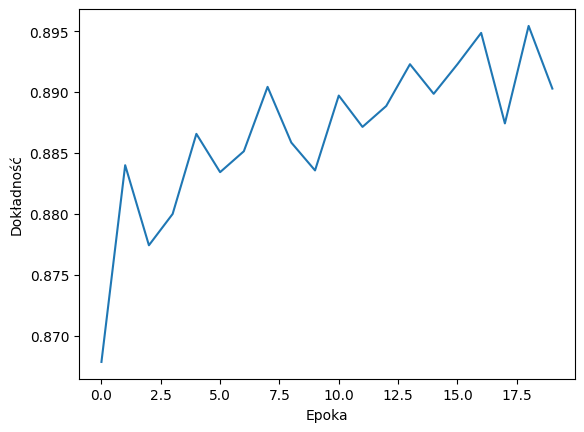

In [ ]:
plt.plot(test_errors)
plt.xlabel("Epoka")
plt.ylabel("Dokładność")

Dla tych przykładowych testów widzimy problemy z sieciami neuronowymi (a przynajmniej niebinarnymi funkcjami aktywacji). Wyjście to nie jest zbiór zer z 1 w odpowiedznim miejscu tylko jest to zbiór pewnych liczb z największą w miejscu gdzie byśmy oczekiwali 1 (zazwyczaj). To oznacza, że sieci neuronowe mogą tylko z pewną dozą niepewności określić czym dane wejście jest. Sieci neuronowe jest to tylko zbiór pewnych funkcji matematycznych które przekształcają tylko dane wejściowe, aby zwrócić oczekiwane wyjście.

#Standardowa sieć neuronowa

Jest ot struktura sieci z którą najczęścije widziałem używaną do tego problemu. Będzie ona służyła jako odnośnik



In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

start = time.time()
np.random.seed(4)
neural_network = Network([FullyConnected(784, 40),Tanh(), FullyConnected(40, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)

print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.702
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.906
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.918
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.92
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.928
Took 98.1309928894043
Accuracy after 5 epochs: 0.9045714285714286


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(42)
start = time.time()
neural_network = Network([FullyConnected(784, 40),Tanh(), FullyConnected(40, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print(f"Took {time.time() - start}")

print(f"Accuracy after 5 epochs: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.838
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.896
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.91
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.9
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.918
Accuracy after 5 epochs: 0.9115714285714286


#Porównanie architektur pierwsze ziarno


Porównuje tu trochę bardziej nietypowe struktory (zamiast prostej powtwrzającej się pary FullyConnected Tanh i pzrzystej ilości warstw)

In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

**Wejście i wyjście to Tanh a warstwa ukryta to Fully Connected**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(4)
start = time.time()
neural_network = Network([Tanh(), FullyConnected(784, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first architecture: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.724
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.734
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.774
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.77
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.712


Took 46.76754713058472
Accuracy after 5 epochs for first architecture: 0.719


Ta architektura szybko kończy 5 epok bo już poniżej 50 sekund, ale od 3 epoki nie może wznieść się ponad dokładność 80%. Obie te rzeczy są połączone ponieważ układ ten cierpi na niewystarczającą ilość wag i nie za bardzo możemy coś z tym zrobić ponieważ musimy mieć określoną ilość wyjść i wejść, a warstwy Tanh nie zmieniaja tych liczb.

**Dwie warstwy FullyConnected i jedna warstwa Tanh**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(4)
start = time.time()
neural_network = Network([FullyConnected(784, 40), Tanh(), FullyConnected(40, 10)], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first second: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.854
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.91
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.906
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.92
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.948


Took 76.96481680870056
Accuracy after 5 epochs for first second: 0.9164285714285714


W tym wypadku zmniejszyliśmy liczbę warstw Tanh do 1 w stosunku do "standardowej" architektury i na wyjściu teraz mamy warstwę FullyConnected. Dzięki temu uzyskaliśmy mniejszy czas obliczeń (około 14 sekund szybciej) oraz w przypadku pierwszego ziarna lepsze wyniki co jest pozytywem. Przyspieszony czas obliczeń może wynikać, z tego że iterujemy po jedej mniej warstwie co przez cały czas obliczeń się na siebie nakłada i generuje tak dużą róznicę. Większa dokładność jest lekkim zaskoczeniem, ale może być ona spowodowana tym, że pierwszy błąd jest bezpośrednio "przekazywany" w propagacji wstecznej do warstwy która posiada wagi czyli tej którą możemy modyfikowac aby uzyskać wyniki.

**Dwie warstwy FullyConnected i jedna warstwa Tanh, mniejsza liczba neuronów w warstwie Tanh**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(4)
start = time.time()
neural_network = Network([FullyConnected(784, 20), Tanh(), FullyConnected(20, 10)], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first second: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.5820000000000001
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.9
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.89
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.922
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.91


Took 62.184916496276855
Accuracy after 5 epochs for first second: 0.903


Przy zmniejszeniu ilości neuronów w warstwie ukrytej Tanh dokładnośc zmniejszyła się o około 1,5%, czego można było się spodziewać bo zmniejszyliśmy liczbę modyfikowalnych parametrów. Ale za to algorytm zakończył się o 14 sekund szybciej co znacząco przeważa nieznaczna stratę w dokładności.

#Porównanie architektur drugie ziarno


**Wejście i wyjście to Tanh a warstwa ukryta to Fully Connected**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(42)
start = time.time()
neural_network = Network([Tanh(), FullyConnected(784, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first architecture: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.76
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.744
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.782
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.736
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.748


Took 45.61411142349243
Accuracy after 5 epochs for first architecture: 0.7198571428571429


W przypadku drugiego ziarna dla pierwszej architektóry błąd się nie poprawi i to tylko potwierdza, że w tym wypadku brakuje nam wag które można dostroć.

**Dwie warstwy FullyConnected i jedna warstwa Tanh**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(42)
start = time.time()
neural_network = Network([FullyConnected(784, 40), Tanh(), FullyConnected(40, 10)], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first second: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.872
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.92
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.926
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.9
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.914


Took 77.42742586135864
Accuracy after 5 epochs for first second: 0.9121428571428571


Dla drugiej architektóry dokładność nieznacznie zmalała (o około 0.5%), ale nadal jest nieco większa niż dla standardowej architektury. Utzrymywanie sie dokładności podpowiada, że ta architektura otrzymuje nieco bardziej stabilne wyniki dla różnych zbiorów (na podstawie tych dwóch ziarn). Więc w ogólnym wypadku ta architektóra prawdopodobnie byłaby lepsza bo daje bardziej stabilne wyniki w krótszym czasie. Jedynym minusem jest fakt, że w tym wypadku wyniki mogą być dowolną liczbą rzeczywistą, a dla standardowej architektury wejście to zawsze wartości między -1 i 1.

**Dwie warstwy FullyConnected i jedna warstwa Tanh, mniejsza liczba neuronów w warstwie Tanh**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(42)
start = time.time()
neural_network = Network([FullyConnected(784, 20), Tanh(), FullyConnected(20, 10)], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first second: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.748
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.838
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.902
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.91
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.912


Took 60.92358589172363
Accuracy after 5 epochs for first second: 0.9024285714285715


#Bardziej "egzotyczne" architektury

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(4)
start = time.time()
neural_network = Network([FullyConnected(784, 40), FullyConnected(40, 40), Tanh(), FullyConnected(40, 10)], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)
print("\n")
print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs for first architecture: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x7eefbdd9b640>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.118
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.29000000000000004
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.886
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.9299999999999999
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.944


Took 118.24507546424866
Accuracy after 5 epochs for first architecture: 0.9031428571428571


Ta architektura daje bardzo ciekawe wyniki, ponieważ na początku dokładnośc jest bardzo mała a nastęnie po 3 epochu dokładnośc na danych testowych wzrosła o 60 punktów procentowych oraz pod koniec dokładność nie odbiega znacznie od dokładnosci dla "standardowej" architektury. W tym przypadku czas obliczeń na jest znaczny co wynika ze zwiększonej liczby wag. To również może być powodem tak nagłego skoku dokładności, ponieważ w pewnym momencie zaszło dużo niewielkich, odpowiednich zmian który razem spowodowały wiekszą zmianę.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

np.random.seed(4)
neural_network = Network([FullyConnected(784, 20),Tanh(), FullyConnected(20, 10), Tanh(), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 5, 2)

print(f"Accuracy after 5 epochs: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x78c7be294820>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.5820000000000001
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.758
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.694
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.764
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.838
Accuracy after 5 epochs: 0.8109999999999999


In [ ]:
x, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

start = time.time()
np.random.seed(4)
neural_network = Network([FullyConnected(784, 40),Tanh(), FullyConnected(40, 40), Tanh(), FullyConnected(40, 10), Tanh()], 0.1)
neural_network.compile(Loss(mean_square_error, mean_square_error_deriviative))
neural_network.fit(normalize_input(x_train), normalize_expected_output(y_train, 10), 20, 2)

print(f"Took {time.time() - start}")
print(f"Accuracy after 5 epochs: {neural_network.measure_accuracy(normalize_input(x_test), normalize_expected_output(y_test, 10))}")

<function mean_square_error_deriviative at 0x79e2ded4cdc0>
Epoch 1 started
Epoch 1 ended
Current accuracy: 0.19999999999999996
Epoch 2 started
Epoch 2 ended
Current accuracy: 0.236
Epoch 3 started
Epoch 3 ended
Current accuracy: 0.19799999999999995
Epoch 4 started
Epoch 4 ended
Current accuracy: 0.19599999999999995
Epoch 5 started
Epoch 5 ended
Current accuracy: 0.21199999999999997
Epoch 6 started
Epoch 6 ended
Current accuracy: 0.21599999999999997
Epoch 7 started
Epoch 7 ended
Current accuracy: 0.22399999999999998
Epoch 8 started
Epoch 8 ended
Current accuracy: 0.22799999999999998
Epoch 9 started
Epoch 9 ended
Current accuracy: 0.18799999999999994
Epoch 10 started
Epoch 10 ended
Current accuracy: 0.21199999999999997
Epoch 11 started
Epoch 11 ended
Current accuracy: 0.22999999999999998
Epoch 12 started
Epoch 12 ended
Current accuracy: 0.20199999999999996
Epoch 13 started
Epoch 13 ended
Current accuracy: 0.20599999999999996
Epoch 14 started
Epoch 14 ended
Current accuracy: 0.20199999999

#Wnioski

Sieci neuronowe mają duży poencjał, jeżeli się je dobrze użyje, ale łatwo jest też popełnić błąd w doborze architektury i funkcji aktywacji.

W tej implementacji warto by było uwzględnic updatowanie wag po określonej ilości próbek testowych (co można zreaalizować przez dodanie countera do warstw), co użredniłoby zmiany. Ale wydłużyloby to nieco czas potrzebny do obliczenia dobrej sieci. Dodatkowo jeżeli spojrzymy na to większość sieci osiąga zadawalający wynik na zbiorze testowym po 2-3 epochach. Jest to bardzo dobry rezultat, ale jest częściowo spowodowany tym, że w każdym epochu używamy wszystkich danych testowych, co również wydłuża przebieg uczenia (powoduje to duża ilość danych co jest bardzo porządane). Dla mniejszej ilości danych w przykładzie bramiki XOR, możan było zauważyć że algorytm miał spore trudności z osiągnięciem dużej dokładności. Dobra również jest spora różnorodność danych co pomaga pokryc duży zakres przypadków.

